# Model Free

### Description: 

In this session, we are exploring a simple version of a game
(simpler version of Perudo: https://www.youtube.com/watch?v=die0n-eonl8).
Using the rules of the game, we first construct an environment. 
  
There is below a simple code where the game is played using a random statregy.

Also, there are two functions to display the optimal value functions and optimal policies.


### TO DO:

1) Implement MC, SARSA, Q-learning to learn the value function. It is recommended to use the indications of code below.


2) For the 3 cases, display the value function and the optimal policy found. 


Bonus track (Facultative)

3) Create a new environment which takes as parameter a given policy. Then implement iterations where you find the optimal value function for a given adversarial policy and then you play in turn against this policy.
Display the results after some iterations. Comment.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 


In [11]:
import gym
import numpy as np
import random
from gym import spaces
from gym.utils import seeding
import sys
from collections import defaultdict

THE GAME

**Rules**:

- 2 players 
- Each player has 5 coins (head or tail). Each player only sees her coins.  
- After flipping each coin, the game starts.
- The game consists in guessing how many heads are present between all coins (or make the other player guess wrongly).
- Bets start at 0 head.
- The starting player is chosen at random. (Flip a coin)
- Possible actions:
    * the player keeps the actual bet and passes.
    * the player add 1 to the actual bet (estimate of the total number of heads).
- The game stops when one player passes.
- if the bet is strictly bigger than the real number, the last player to play looses (r=-1) and the other wins (r=1). if the bet is smaller or equal, the last player wins (r=1) and the other looses (r=-1).
- IA initialisation of the computer strategy: if the bet  is smaller than 2+ quantity of observed own heads, bets, otherwise passes.

In [3]:
# Environment and rules

def throw_coin(num_coin, np_random):
    return np_random.rand(num_coin)>0.5

def total_faces(list_players):
    RV=0
    for player in list_players:
        RV += sum(player)
    return RV

class PerudoSimplificado(gym.Env):
    def __init__(self):
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), #mis monedas
            spaces.Discrete(10))) #apuesta actual

        self.seed()
        # Empieza el juego
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        max_guess_player_2 = total_faces([self.player_2]) + int(len(self.player_1)/2)
        faces_tot = total_faces([self.player_1, self.player_2])
        
        if self.guess > len(self.player_1) + len(self.player_2): #the bet is bigger than the max possible
            done = True
            reward = -1

        if action == 0: #action == 0, maintain the bet and pass 
            done = True
            if self.guess <= faces_tot: #the other player was right
                reward = -1
            else: #I was right
                reward = -1
            
        else: #action == 1, add 1 in the bet 
            self.guess += 1
            if self.guess < max_guess_player_2: # the other player adds 1
                self.guess += 1 
                done = False
                reward = 0
            else: # other player passes
                done = True
                if self.guess <= faces_tot: 
                    reward = 1
                else:
                    reward = -1
            
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum(self.player_1), self.guess)
    
    def reset(self):
        self.player_1 = throw_coin(5,self.np_random)
        self.player_2 = throw_coin(5,self.np_random)
        self.guess = 1 if np.random.rand()>0.5 else 0 # flip a coin to see who starts.
        return self.get_obs()

## Playing at random

In [4]:
env = PerudoSimplificado()
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(5), Discrete(10))
Discrete(2)


In [5]:
#Politica Random:
for i_episode in range(5):
    state = env.reset()
    while True:
        action = env.action_space.sample() # Selects a random action 
        state, reward, done, info = env.step(action) # Plays one round
        print(state,action)
        if done:
            print('Game over! Your reward: ', reward)
            print('You win :)\n') if reward > 0 else print('You lost:(\n')
            break

(2, 2) 1
(2, 2) 0
Game over! Your reward:  -1
You lost:(

(3, 0) 0
Game over! Your reward:  -1
You lost:(

(1, 1) 0
Game over! Your reward:  -1
You lost:(

(2, 1) 0
Game over! Your reward:  -1
You lost:(

(3, 0) 0
Game over! Your reward:  -1
You lost:(



## Plots:

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_values(V):
    """
    Does a 3D display of the value function.
        
    The parameter V describes the value function in function of the number of "heads in your hand"
    and "actual bet".
    """
    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('heads')
        ax.set_ylabel('bets')
        ax.set_zlabel('value')
        ax.view_init(ax.elev, -120)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    get_figure(ax)
    plt.show()

In [7]:
def plot_policy(policy):
    """
    3D graphic of value function.
    
     policy is a function of "heads" 
     and "bets" and the value is the action to be realized.
    """
    def get_Z(x, y):
        if (x,y) in policy:
            return policy[x,y]
        else:
            return 25 # this value is to vizualize that there is no action yet defined for this state
             

    def get_figure( ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(0, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y) for x in x_range] for y in y_range])
        surf = ax.imshow(np.flip(Z,0), cmap=plt.get_cmap('Pastel2', 3), vmin=0, vmax=2, extent=[-0.5, 5.5, -0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('heads')
        ax.set_ylabel('bets')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (pass)','1 (up)', 'unknown'])
        print(Z)
            
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    get_figure(ax)
    plt.show()

## Monte Carlo

In [8]:
def get_probs(Q_s, epsilon, nA): 
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  

def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode


def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [9]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Episode 500000/500000.

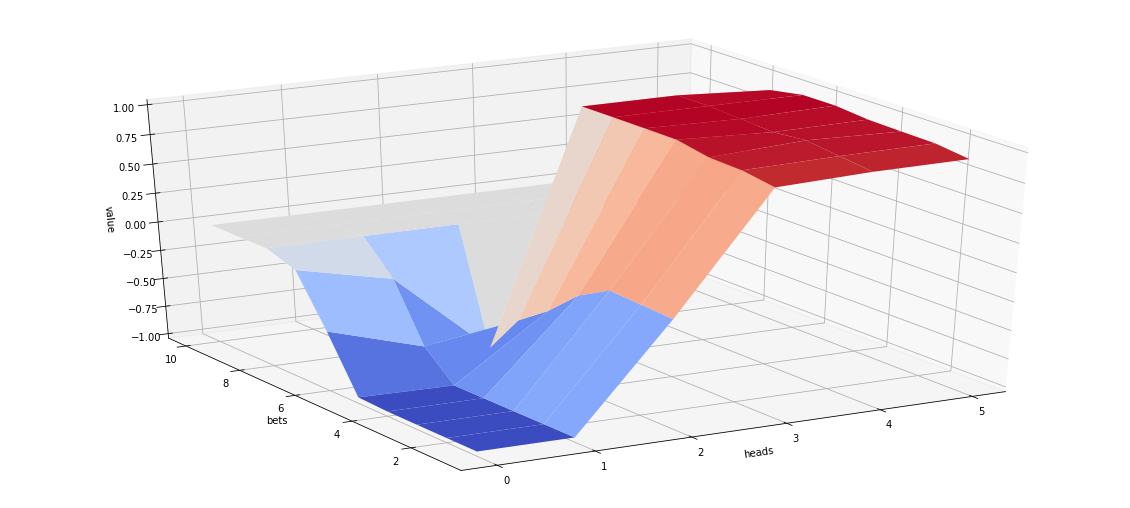

In [12]:
# Compute  the optimal policy and value function
policy, Q = mc_control(env, 500000,0.015)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_values(V)

[[ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 1  0  1  1  1  1]
 [ 0  1  1  1  1  1]
 [ 1  0  1  1  1  1]
 [ 1  1  1  1  1  1]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]


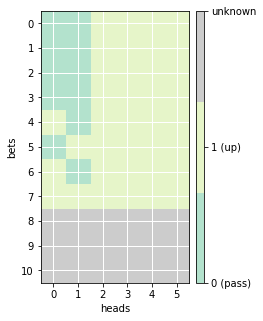

In [13]:
# plot the policy
plot_policy(policy)

## SARSA

In [14]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current = Q[state][action] 
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value
    
def epsilon_greedy(Q, state, nA, eps):
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [15]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n                
    Q = defaultdict(lambda: np.zeros(nA))  
   
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             
        state = env.reset()                                   
        
        eps = max(1.0 / i_episode, epsmin)                           
        action = epsilon_greedy(Q, state, nA, eps)            

        while True:
            next_state, reward, done, info = env.step(action) 
            score += reward                                   
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) 
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                break
                
    return Q

Episode 500000/500000

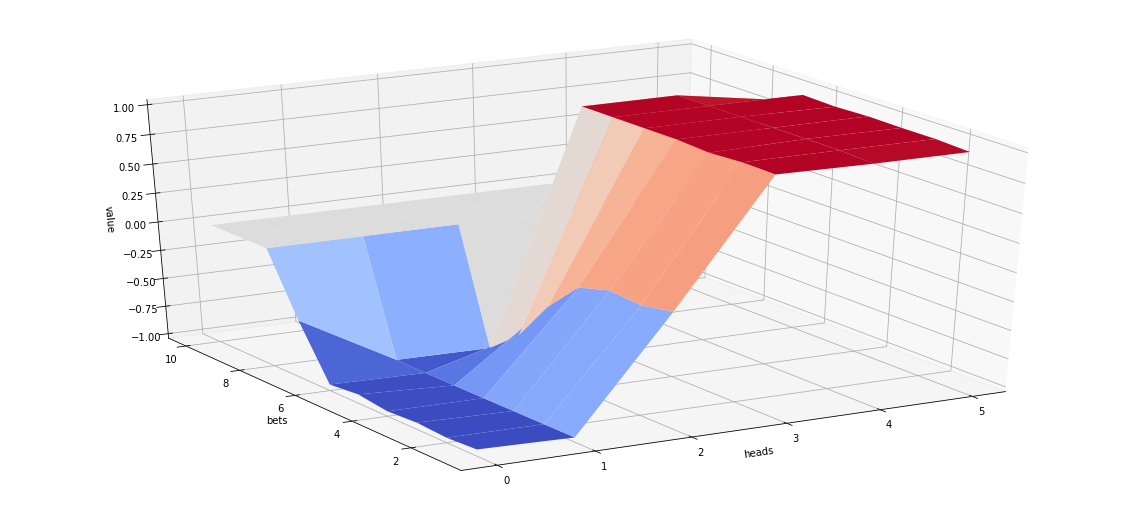

In [16]:
# Compute  the optimal policy and value function
Q_sarsa = sarsa(env, 500000, 0.009)
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())
plot_values(V)

[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 1  0  1  1  1  1]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]


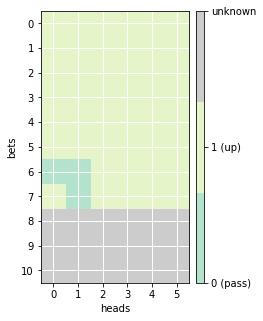

In [17]:
# plot
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
plot_policy(policy_sarsa)

## Q-learning

In [18]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [19]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = max(1.0 / i_episode ,epsmin)                                 # set value of epsilon
        
                
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            # note: no A <- A'
            if done:
                break
    return Q

Episode 500000/500000

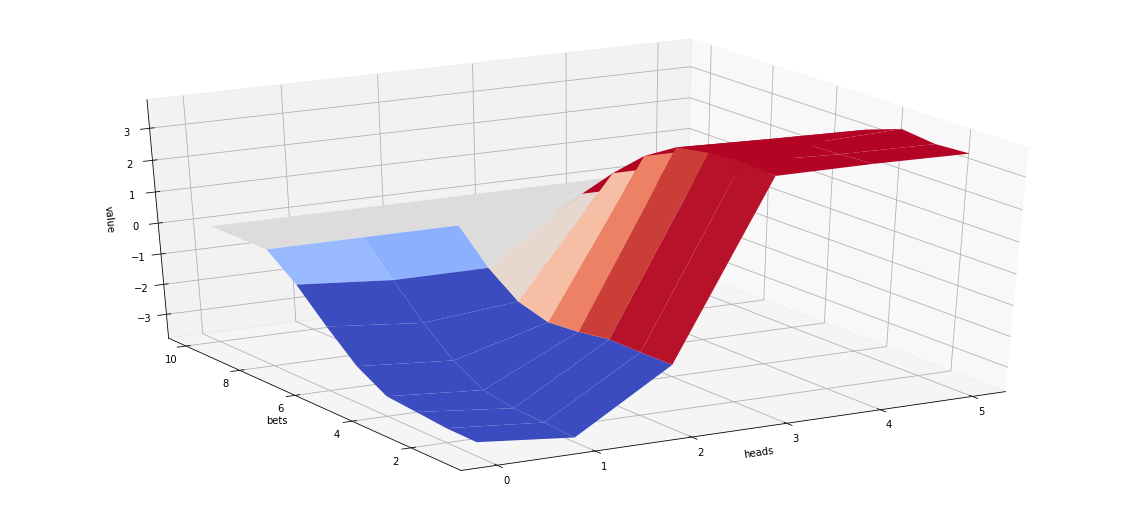

In [20]:
# Compute  the optimal policy and value function
Q_sarsamax = q_learning(env, 500000, 0.01)
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())
plot_values(V)

[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 0  0  0  0  0  0]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]


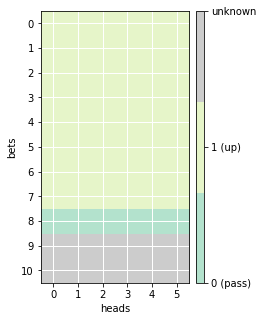

In [21]:
# plot
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
plot_policy(policy_sarsamax)